<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Защита персональных данных клиентов

Нам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработаем такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. 

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## Загрузка данных

In [1]:
#импортируем необходимые нам библиотеки и инструменты
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
#прочитаем датасет
df = pd.read_csv('/datasets/insurance.csv')

#выведем первые пять строк
df.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [3]:
#просмотрим общую информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


Пропуски в данных отсутствуют. 
Признаки: пол, возраст и зарплата застрахованного, количество членов его семьи.
Целевой признак: количество страховых выплат клиенту за последние 5 лет.
Можно было бы привести к целочисленному значению значения признака "Возраст", но для текущей задачи нам это не важно.

In [4]:
#посмотрим как коррелируют признаки между собой
df.corr()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
Пол,1.000000,0.002074,0.014910,-0.008991,0.010140
Возраст,0.002074,1.000000,-0.019093,-0.006692,0.651030
Зарплата,0.014910,-0.019093,1.000000,-0.030296,-0.014963
Члены семьи,-0.008991,-0.006692,-0.030296,1.000000,-0.036290
Страховые выплаты,0.010140,0.651030,-0.014963,-0.036290,1.000000


Видно, что целевой признак "Страховые выплаты" значительно коррелирует с признаком "Возраст". Посмотрим на это графически.

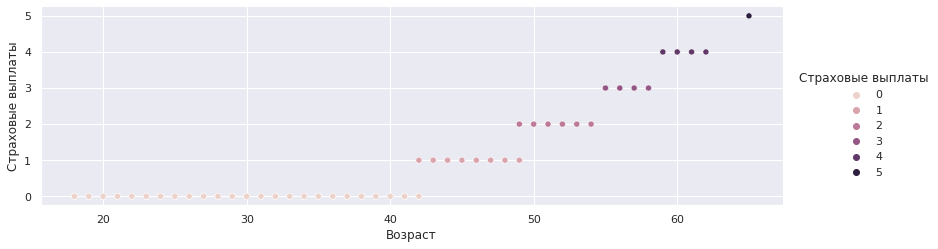

In [5]:
sns.set(rc={'figure.figsize':(10,10)})
sns.set_style('darkgrid')
sns.pairplot(data=df, y_vars=['Страховые выплаты'], x_vars=['Возраст'], hue='Страховые выплаты', height=3.5, aspect=3.2)
plt.show()

## Умножение матриц

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:** при умножении признаков на обратимую матрицу качество линейной регрессии не изменится

**Обоснование:** умножение признаков на обратимую матрицу приведет к изменению значений признаков, но не изменит их линейной зависимости друг от друга. Следовательно, линейные коэффициенты, полученные при обучении, также не изменятся, и качество линейной регрессии останется неизменным.

Параметры линейной регрессии в исходной задаче и в преобразованной будут связаны матричным умножением. Если мы умножим матрицу признаков X на обратимую матрицу Р, то получим новую матрицу признаков X' = XP. Тогда параметры линейной регрессии для новой матрицы признаков можно найти как:

$$
w' = ((XP)^T XP))^{-1} (XP)^T y
$$

Раскрывая скобки, получим:

$$
w' = (X^T P^T X P)^{-1} X^T P^T y
$$

Заметим, что $P^T$ является обратной к $P$ матрицей, поэтому:

$$
(P^T X^T X P)^{-1} = P^{-1} (X^T X)^{-1} (P^T)^{-1}
$$,

подставляя это выражение в уравнение для w', получаем:

$$
w' = P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y,
$$
или
$$
w' = P^{-1} w
$$

т.к. формула предсказаний нам известна, то пропишем формулу предсказаний для новой матрицы


$$
a' = XP(P^{-1}) w
$$
получается

$$
a' = Xw
$$
Получается, что вектор предсказаний исходной матрицы равен вектору предсказаний матрицы помноженной на обратимую матрицу,что мы и доказали. Качество регрессии не поменяется.

## Алгоритм преобразования

1. Разделим данные на признаки (матрица X) и целевой признак (y).

2. Вычислим параметры линейной регрессии w для исходных данных.

3. Сгенерируем случайную обратимую матрицу P.

4. Умножим матрицу признаков X на матрицу P для получения преобразованных данных XP = X * P.
5. Вычислим новые параметры линейной регрессии w' для преобразованных данных (XP, y) с использованием уравнения 
$
w' = (XP^T XP)^{-1} XP^T y.
$
6. Оценим качество линейной регрессии на преобразованных данных, используя метрику $R^2$.
7. Сравним качество линейной регрессии на исходных данных (X, y) с качеством на преобразованных данных (XP, y). Если качество не изменилось или улучшилось, то можно использовать преобразованные данные для построения модели.

## Проверка алгоритма

Проверим алгоритм. Обучим модель на исходных данных и выведем значение метрики R2.

In [6]:
#выделим признаки и целевой признак 
features = df.drop(['Страховые выплаты'], axis=1)
target = df['Страховые выплаты']

#разобьем признаки и целевой признак на 2 группы, отделив обучающие данные от тестовых
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=12345)

#проверим кол-во строк
display(features_train.shape)
display(features_test.shape)
display(target_train.shape)
display(target_test.shape)

(4000, 4)

(1000, 4)

(4000,)

(1000,)

In [7]:
#создадим pipline
model_lr = make_pipeline(StandardScaler(), LinearRegression())

#обучим модель
model_lr.fit(features_train, target_train)

#получим предикты
predictions = model_lr.predict(features_test)

#посчитаем и выведем R2
r2 = r2_score(target_test, predictions)
print('Метрика R2 на исходных данных', r2)

Метрика R2 на исходных данных 0.4117683956770476


Теперь обучим модель на зашифрованных данных. Создадим произвольную матрицу по длине совпадающую с шириной нашей выборки и проверим ее обратимость.

In [8]:
trans_df = features_train.shape[1]
while True:
    P = np.random.rand(trans_df, trans_df)
    if np.linalg.det(P) != 0:
        break
P

array([[0.84258663, 0.74179974, 0.02553736, 0.31941531],
       [0.68490508, 0.59020954, 0.06034414, 0.07355692],
       [0.18737455, 0.63359821, 0.49440603, 0.83432101],
       [0.91469587, 0.70713906, 0.15105507, 0.13951021]])

Далее умножим созданную матрицу на тренировочные и тестовые данные. Потом обучим на преобразованных данных модель и посчитаем значение метрики R2 на преобразованных данных

In [9]:
new_features_train = features_train.dot(P)
new_features_test = features_test.dot(P)
model_lr.fit(new_features_train, target_train)
new_predictions = model_lr.predict(new_features_test)
new_r2 = r2_score(target_test, new_predictions)
print('Метрика R2 на преобразованных данных', new_r2)

Метрика R2 на преобразованных данных 0.4117683956768796


**ВЫВОД:** если умножить матрицу признаков исходного датасета на обратимую матрицу, не изменяя значения целевой переменной, то это не повлияет на качество предсказания модели. Другими словами, метрика оценки качества модели (например, коэффициент детерминации R2) останется прежней, даже если исходные данные были трансформированы с помощью обратимой матрицы.